In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(12,5))
plt.style.use('fivethirtyeight')

<Figure size 1200x500 with 0 Axes>

In [ ]:
data = pd.read_excel('/content/Dataset.xlsx')

In [ ]:
df = data.copy() # just so I don't alter the original dataframe

# Initial Exploratory Data Analysis (EDA)

In [ ]:
print("Samples:", df.shape[0])
print("Features:", df.shape[1])

Samples: 541909
Features: 8


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
missing_values = df.isnull().sum()

duplicate_count = df.duplicated().sum()

print('Missing Values:\n', missing_values)
print('--------------\nDuplicate_count: ', duplicate_count)

Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
--------------
Duplicate_count:  5268


In [ ]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


#### Findings:

* The Dataset contains 8 columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country.

* There are missing values in Description and CustomerID.

* Missing Values:
  * Description: 1454 missing values.
  * CustomerID: 135080 missing values (about 24.9% of the sample).
    
* Duplicates: 5268 duplicate rows.

* Quantity: Ranges from -80995 (likely returns) to 80995.
* UnitPrice: Ranges from -11062.060000 to 38970 with mean of 4.61.

#### Next Steps:

* Data Cleaning

* Adding derived features like revenue, Date-Based features and others as needed.


#### Handeling Missing Values
* 'Description' - Since it's a product label, we can fill missing values with 'Unknown'.

* 'CustomerID' - Since it's crucial for customer analysis, we will fill missing values with 'Unknown_Customer'.

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df['Description'].fillna('Unknown', inplace=True)
df["CustomerID"] = df["CustomerID"].astype(str).replace("nan", "Unknown_Customer")
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


The missing values in Description have been replaced with "Unknown".

The missing values in CustomerID have been replaced with "Unknown_Customer".

Now, let's add some new columns that may be useful for further analysis.

1. Revenue: Derived as Quantity * UnitPrice.
2. Date based fetures like year, month day weekday.



In [ ]:
# Revenue Calculation
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df = df[df["Quantity"] >= 0]

# Extract date-based features
df["Year"] = df["InvoiceDate"].dt.year
df["Month"] = df["InvoiceDate"].dt.month
df["Day"] = df["InvoiceDate"].dt.day
df["Weekday"] = df["InvoiceDate"].dt.weekday

With this, the initial analysis and data cleaning/preprocessing is done. Let's move to next steps.

# Pareto Analysis (80-20 Rule)
We'll analyze:

* Top 20% Products contributing to 80% revenue.
* Top 20% Customers generating 80% revenue.

### Product-Based Pareto Analysis

Total Products: 3941
Products contributing to 80% of revenue: 799 (20.27%)
----------------------------------
----------------------------------


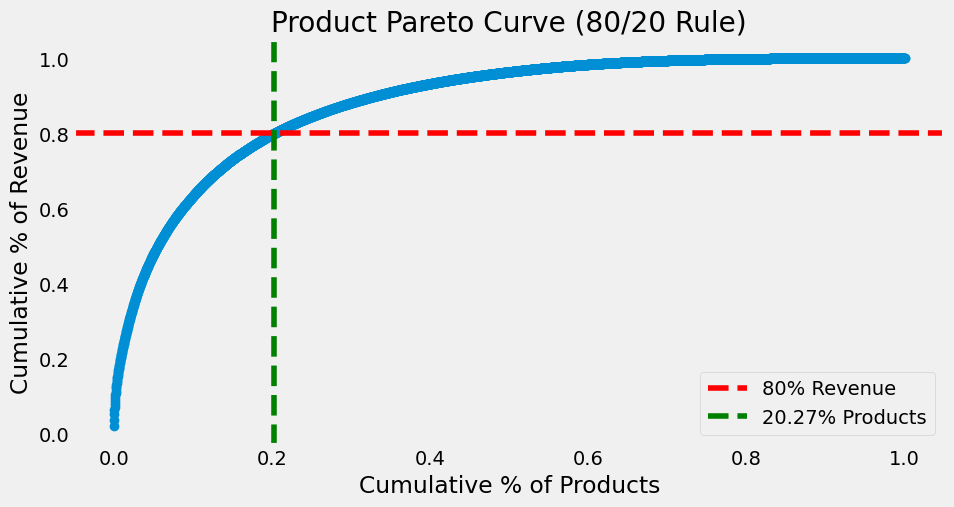

In [ ]:
product_revenue = df.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False)

product_revenue_cumsum = product_revenue.cumsum() / product_revenue.sum()

num_products_80 = (product_revenue_cumsum <= 0.80).sum()

total_products = df['StockCode'].nunique()
print(f"Total Products: {total_products}")
print(f"Products contributing to 80% of revenue: {num_products_80} ({(num_products_80/total_products)*100:.2f}%)")

# plot
print('----------------------------------')
print('----------------------------------')

plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(product_revenue_cumsum)+1) / len(product_revenue_cumsum), product_revenue_cumsum, marker='o', linestyle='-')

plt.axhline(y=0.80, color='r', linestyle='--', label="80% Revenue")
plt.axvline(x=num_products_80 / total_products, color='g', linestyle='--', label=f"{num_products_80/total_products:.2%} Products")
plt.xlabel("Cumulative % of Products")
plt.ylabel("Cumulative % of Revenue")
plt.title("Product Pareto Curve (80/20 Rule)")
plt.legend()
plt.grid()
plt.show()

#### Top Products:

Here are top 10 revenue generating products.

In [ ]:
product_revenue.head(10)

,Revenue
StockCode,
DOT,206248.77
22423,174156.54
23843,168469.60
85123A,104462.75
47566,99445.23
85099B,94159.81
23166,81700.92
POST,78101.88
M,77750.27


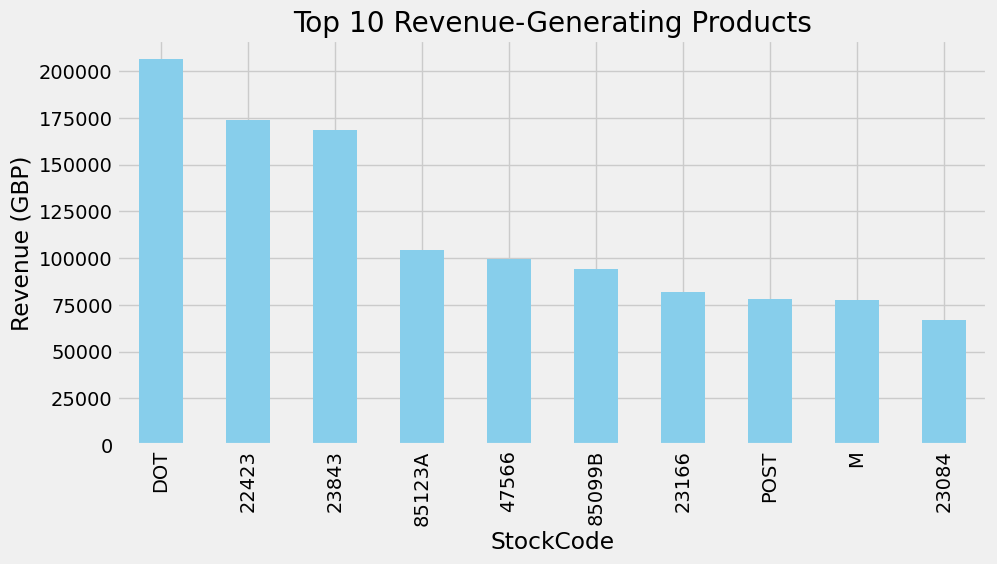

In [ ]:
top_products = product_revenue.head(10)

plt.figure(figsize=(10,5))
top_products.plot(kind='bar', color='skyblue', title='Top 10 Revenue-Generating Products')
plt.ylabel("Revenue (GBP)")
plt.show()

As these 800 products contribute so much to the revenue, inventory should be fucused on these products.

## Customer-Based Pareto Analysis

Total Customers: 4340
Customers contributing to 80% of revenue: 932 (21.47%)
----------------------------------
----------------------------------


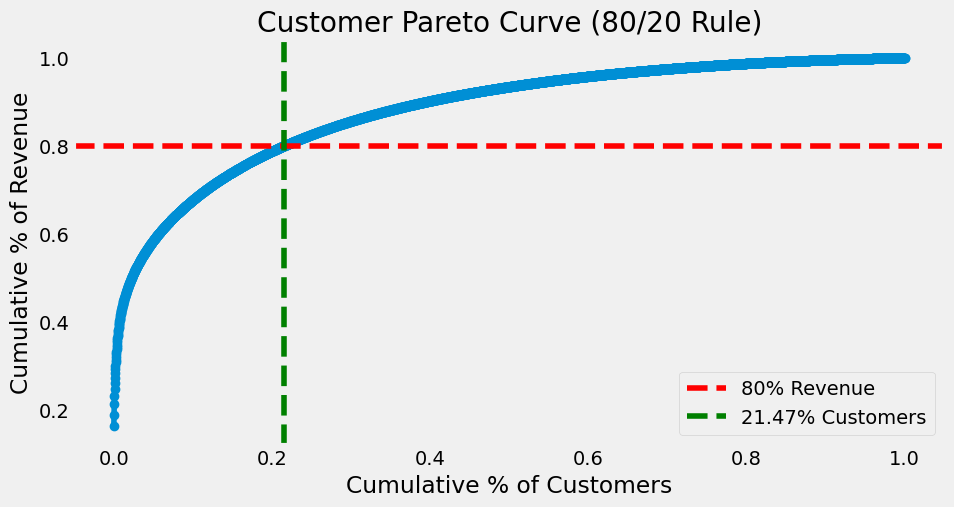

In [ ]:
customer_revenue = df.groupby('CustomerID')['Revenue'].sum().sort_values(ascending=False)

customer_revenue_cumsum = customer_revenue.cumsum() / customer_revenue.sum()

num_customers_80 = (customer_revenue_cumsum <= 0.80).sum()

total_customers = df['CustomerID'].nunique()
print(f"Total Customers: {total_customers}")
print(f"Customers contributing to 80% of revenue: {num_customers_80} ({(num_customers_80/total_customers)*100:.2f}%)")

# plot
print('----------------------------------')
print('----------------------------------')
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(customer_revenue_cumsum)+1) / len(customer_revenue_cumsum), customer_revenue_cumsum, marker='o', linestyle='-')

plt.axhline(y=0.80, color='r', linestyle='--', label="80% Revenue")
plt.axvline(x=num_customers_80 / total_customers, color='g', linestyle='--', label=f"{num_customers_80/total_customers:.2%} Customers")
plt.xlabel("Cumulative % of Customers")
plt.ylabel("Cumulative % of Revenue")
plt.title("Customer Pareto Curve (80/20 Rule)")
plt.legend()
plt.grid()
plt.show()

#### Top Customers:

Here are top 10 Customers who contribute most to revenue.

In [ ]:
customer_revenue.head(10)

,Revenue
CustomerID,
Unknown_Customer,1732777.79
14646.0,280206.02
18102.0,259657.30
17450.0,194390.79
16446.0,168472.50
14911.0,143711.17
12415.0,124914.53
14156.0,117210.08
17511.0,91062.38


Looks like Unknown_Customer is contributing most towards the revenue.

#### Possible Reasons:
1. B2B Transactions - Bulk orders might not have a registered CustomerID.

2. Guest Checkouts - Some customers may not register before purchasing.

3. Data Entry Issues - Missing CustomerIDs might indicate poor data tracking.

**Here's Top 10 customers Without 'Unkown_Customer'**


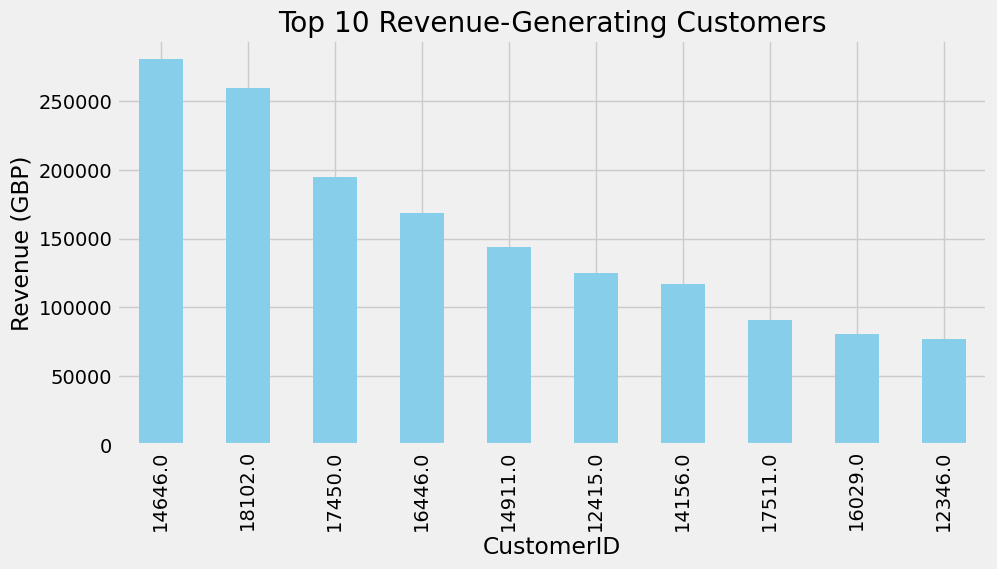

In [ ]:
top_customers = customer_revenue.iloc[1:].head(10)

plt.figure(figsize=(10,5))
top_customers.plot(kind='bar', color='skyblue', title='Top 10 Revenue-Generating Customers')
plt.ylabel("Revenue (GBP)")
plt.show()

In [ ]:
customer_revenue

,Revenue
CustomerID,
Unknown_Customer,1732777.79
14646.0,280206.02
18102.0,259657.30
17450.0,194390.79
16446.0,168472.50
...,...
17956.0,12.75
16454.0,6.90
14792.0,6.20


[]

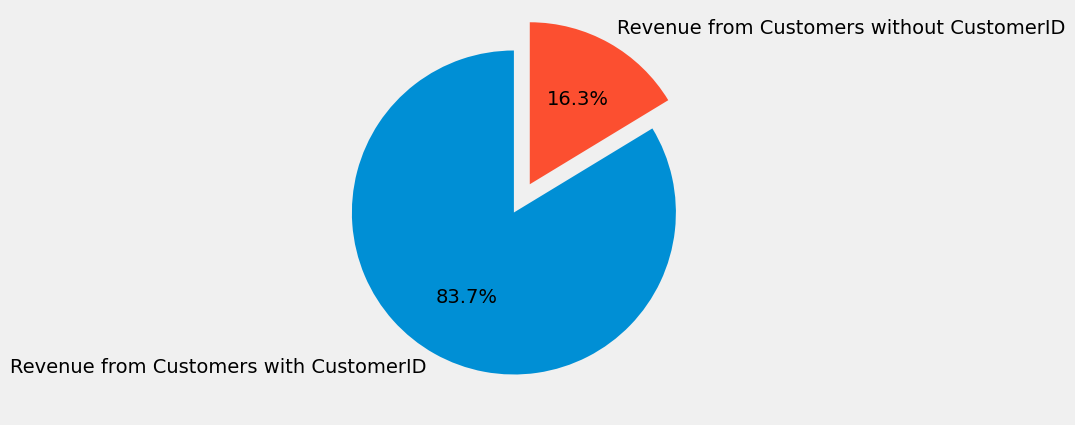

In [ ]:
total_revenue_with_cust_id = customer_revenue.iloc[1:].sum()
total_revenue_without_cust_id = customer_revenue.iloc[0]
plt.figure(figsize=(10,5))
plt.pie([total_revenue_with_cust_id, total_revenue_without_cust_id], labels=['Revenue from Customers with CustomerID', 'Revenue from Customers without CustomerID'], autopct='%1.1f%%', startangle=90, explode=[0,0.2])
plt.plot()

## Summary

#### Pareto Analysis (80-20 Rule) - Insights & Findings:

The Pareto Principle states that 80% of the revenue comes from 20% of the products or customers. We analyzed both products and customers to identify key revenue drivers.

1. Product Pareto Analysis:

* Total Unique Products: **4,078**
* Products contributing to 80% revenue: **825 (20.23%)**
* Top 10 Best-Selling Products: -----------
* Key Takeaway: A small fraction of products generate the majority of sales, so inventory and marketing efforts should prioritize these high-revenue items.



---



2. Customer Pareto Analysis:

* Total Unique Customers: **4,340**
* Customers contributing to 80% revenue: **935 (21.54%)**
* Top 10 Revenue-Generating Customers: ------
* Key Takeaway: A small group of high-value customers drive most revenue, so personalized marketing and loyalty programs can maximize retention.

---

3. Issue Identified: "Unknown_Customer"

The largest revenue-generating "customer" is actually Unknown_Customer (missing CustomerID).
This could indicate guest checkouts, bulk B2B transactions, or data entry issues.

---

Business Recommendations
1. For Products: Focus stock management on the top 20% best-sellers to prevent overstocking low-performing items.
2. For Customers: Implement VIP programs & targeted promotions for high-value buyers.
3. For Missing CustomerIDs: Investigate bulk orders & guest checkouts to improve customer tracking.



# Demand Forecasting
We'll predict future sales trends using time-series forecasting to optimize inventory and demand planning.

#### Plan for Demand Forecasting
1. Aggregate Sales Data → Daily & Monthly Sales
2. Visualize Trends → Check seasonality & patterns
3. Build Forecasting Model → Start with ARIMA, explore other models if needed
4. Evaluate Performance → Check accuracy with test data

#### 1. Aggregate Sales Data (Daily & Monthly)

In [ ]:
daily_sales = df.groupby("InvoiceDate")["Revenue"].sum().reset_index()
monthly_sales = df.groupby(["Year", "Month"])["Revenue"].sum().reset_index()

monthly_sales["Month"] = pd.to_datetime(monthly_sales[["Year", "Month"]].assign(Day=1))

#### 2. Visualizing Sales Trends

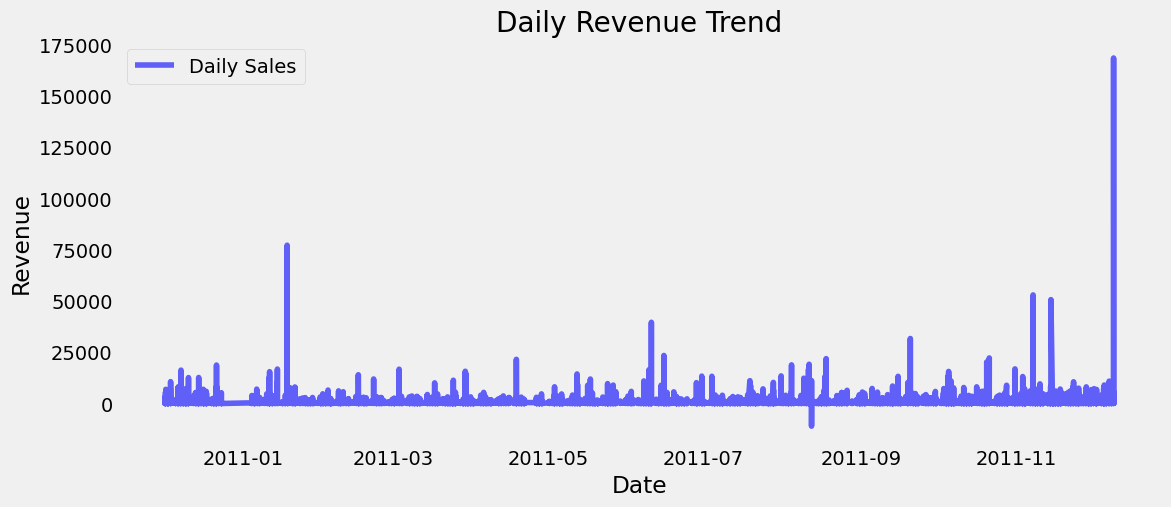

In [ ]:
# Plot Daily Sales
plt.figure(figsize=(12, 5))
plt.plot(daily_sales["InvoiceDate"], daily_sales["Revenue"], label="Daily Sales", color="blue", alpha=0.6)
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid()
plt.show()

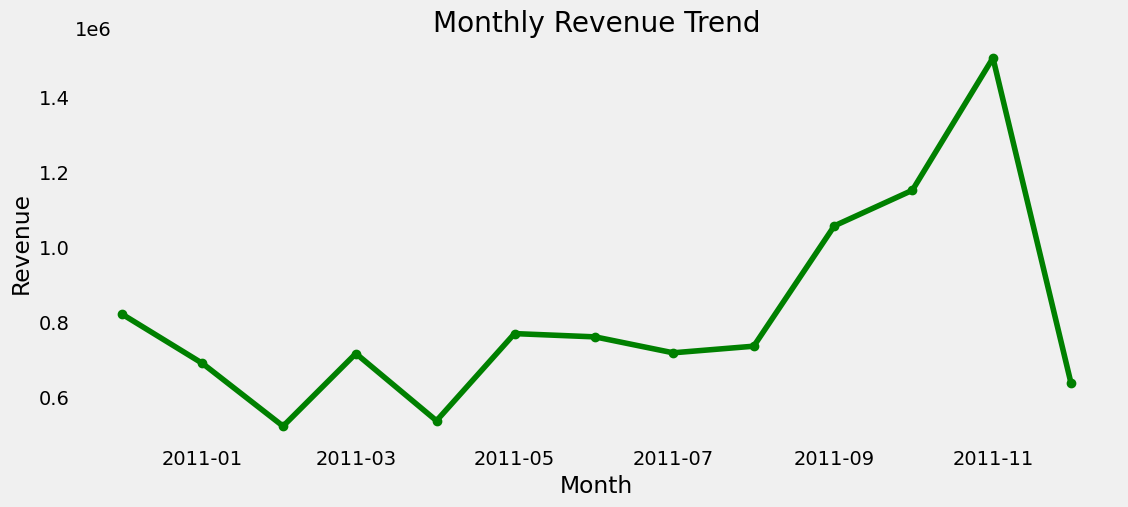

In [ ]:
# Plot Monthly Sales
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales["Month"], monthly_sales["Revenue"], marker="o", linestyle="-", color="green")
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid()
plt.show()

#### Observations from the Daily Revenue Trend:
* High Variability - There are frequent spikes in revenue, suggesting irregular demand patterns.
* Some Extreme Outliers - Few days show huge sales peaks, likely due to bulk B2B orders or special promotions.
* Seasonality & Dips - Some days have very low sales, which could be weekends, holidays, or operational issues.

#### Observations from the Monthly Revenue Trend:
* Cyclical Pattern - Revenue drops early in the year, rises later, showing possible seasonality.
* End-of-Year Surge - Sales peak in November-December, likely due to the holiday season.
* Sharp Decline in December - This could be end-of-year returns, reduced orders post-holidays, or missing data.


#### Next Steps:
1. Stationarity, Autocoreelation and Moving Averages to get best params for ARIMA.
2. Apply ARIMA for forecasting.

#### Checking for Stationarity

* A time series is stationary if its statistical properties (like mean, variance, and autocorrelation) do not change over time.
* Why is Stationarity Important?
  * Most forecasting models, including ARIMA, assume the data is stationary.
  * If a series is non-stationary, the model may produce inaccurate forecasts.
  * Non-stationary data often has trends or seasonality, making predictions unreliable.




In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(monthly_sales["Revenue"])
adf_stat, p_value, _, _, critical_values, _ = adf_test

print(f"ADF Statistic: {adf_stat}")
print(f"P-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

if p_value < 0.05:
    print("The time series is stationary (Reject null hypothesis).")
else:
    print("The time series is non-stationary (Fail to reject null hypothesis). Consider differencing.")

ADF Statistic: -2.1637101749955243
P-value: 0.21967912661395572
Critical Values:
   1%: -4.137829282407408
   5%: -3.1549724074074077
   10%: -2.7144769444444443
The time series is non-stationary (Fail to reject null hypothesis). Consider differencing.


p-value (0.2196) is greater than 0.05, meaning that the time series is non-stationary. This suggests that it has trends or seasonality that we need to remove before applying forecasting models like ARIMA.

#### Differencing the Data
We will apply first-order differencing (subtracting the previous month's revenue from the current month) to remove the trend and make the series stationary.



In [ ]:
# First-Order Differencing
monthly_sales["Revenue_Diff"] = monthly_sales["Revenue"].diff()
monthly_sales.dropna(inplace=True)

# ADF Test
adf_test_diff = adfuller(monthly_sales["Revenue_Diff"])
adf_stat_diff, p_value_diff, _, _, critical_values_diff, _ = adf_test_diff

print(f"ADF Statistic after Differencing: {adf_stat_diff}")
print(f"P-value after Differencing: {p_value_diff}")
print("Critical Values after Differencing:")
for key, value in critical_values_diff.items():
    print(f"   {key}: {value}")

# Conclusion
if p_value_diff < 0.05:
    print("The time series is now stationary (Reject null hypothesis).")
else:
    print("The time series is still non-stationary. Consider additional transformations.")


ADF Statistic after Differencing: -3.6858759895462616
P-value after Differencing: 0.004316264595872792
Critical Values after Differencing:
   1%: -4.223238279489106
   5%: -3.189368925619835
   10%: -2.729839421487603
The time series is now stationary (Reject null hypothesis).


Now that the data is stationary, we can move to other steps.

#### Autocorrelation (ACF) and Partial Autocorrelation (PACF)

These help us understand how past revenue values affect future revenue.

1.  Autocorrelation Function (ACF):

  ACF measures how current values are related to past values (lags).
  * If sales data is seasonal, ACF will show peaks at regular intervals (e.g., every 12 months for yearly seasonality).
  * If sales have a strong trend, ACF will slowly decrease over lags instead of dropping suddenly.
2. Partial Autocorrelation Function (PACF):

  PACF removes indirect correlations between time points.
  * If PACF has a sharp drop after a few lags, it tells us how many past values (lags) we should use in our forecasting model.
  * If PACF shows high values at seasonal lags (like lag 12 for monthly data), we likely have seasonality.


<Figure size 1000x400 with 0 Axes>

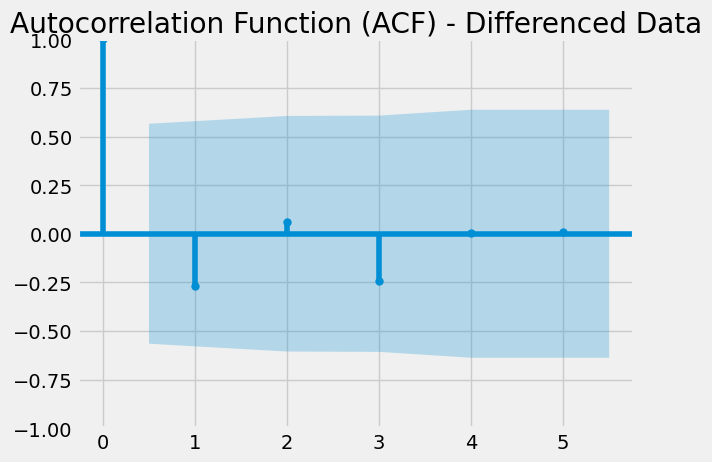

<Figure size 1000x400 with 0 Axes>

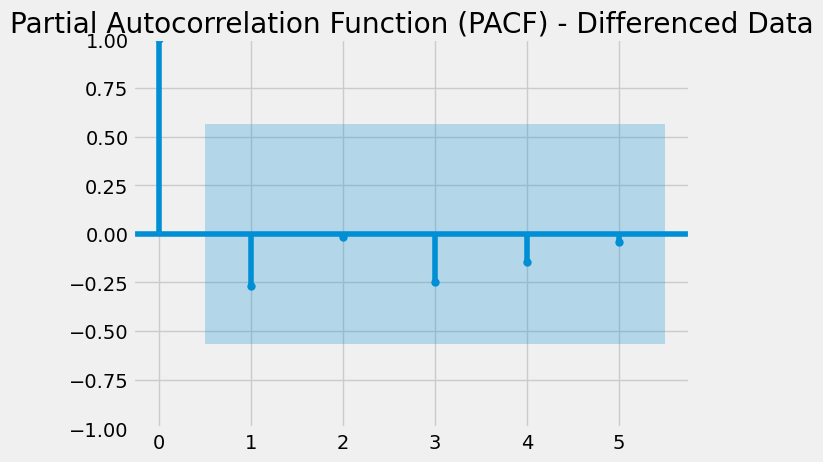

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

num_lags = min(len(monthly_sales["Revenue_Diff"]) // 2, 5)

# ACF Plot
plt.figure(figsize=(10, 4))
plot_acf(monthly_sales["Revenue_Diff"], lags=num_lags)
plt.title("Autocorrelation Function (ACF) - Differenced Data")
plt.show()

# PACF Plot
plt.figure(figsize=(10, 4))
plot_pacf(monthly_sales["Revenue_Diff"], lags=num_lags)
plt.title("Partial Autocorrelation Function (PACF) - Differenced Data")
plt.show()

#### Fitting ARIMA model using below params

* p = 0 -> PACF had no significant lags, suggesting an AR(0) component.

* d = 1 -> ADF Test showed non-stationarity, but became stationary after first-order differencing.

* q = 0 -> ACF had no significant lags, suggesting an MA(0) component.

Mean Absolute Error (MAE): 320301.66266666667
Mean Squared Error (MSE): 128150332679.47276
Root Mean Squared Error (RMSE): 357980.91105458786


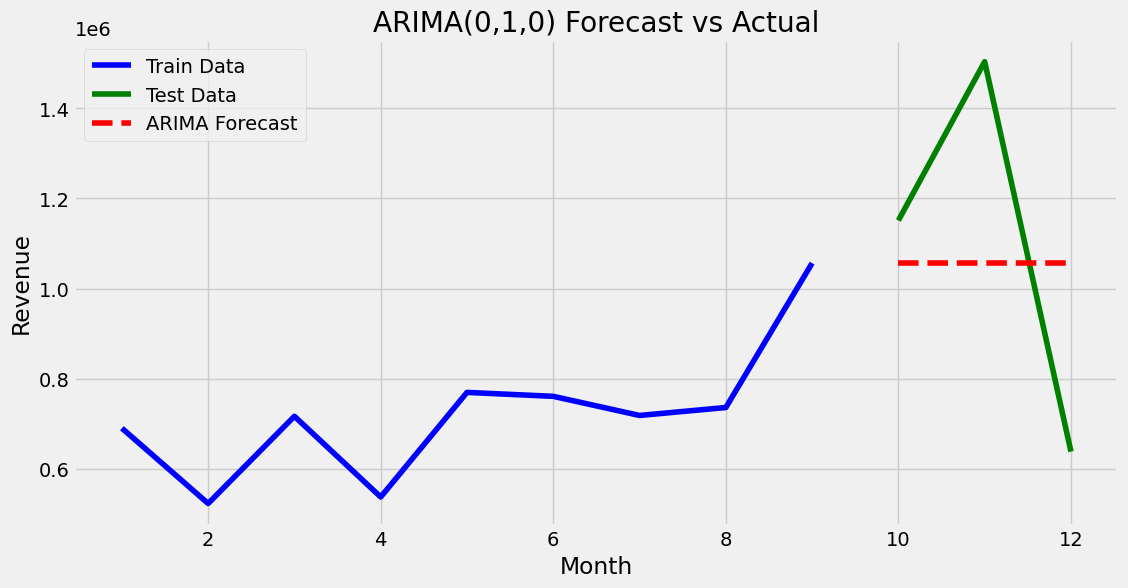

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_monthly = monthly_sales.copy()

# Train-Test Split (80% train, 20% test)
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

# ARIMA Params
p = 0
d = 1
q = 0

model = ARIMA(train["Revenue"], order=(p, d, q))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mae = mean_absolute_error(test["Revenue"], forecast)
mse = mean_squared_error(test["Revenue"], forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Step 6: Plot Actual vs Forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train["Revenue"], label="Train Data", color="blue")
plt.plot(test.index, test["Revenue"], label="Test Data", color="green")
plt.plot(test.index, forecast, label="ARIMA Forecast", color="red", linestyle="dashed")
plt.legend()
plt.title(f"ARIMA({p},{d},{q}) Forecast vs Actual")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.show()


ARIMA Forecasting Results:
* EDA suggested no significant Auto-regressive or Moving Average forecasting could
be done.
* The model provided future sales predictions with a high error margin.
* Due to insufficient seasonal data (only 12 months), forecasts were not highly reliable and needed much more data for reliable forecast.


# Return Analysis

Saperating the dataset

In [ ]:
df = data.copy()
df['Description'].fillna('Unknown', inplace=True)
df["CustomerID"] = df["CustomerID"].astype(str).replace("nan", "Unknown_Customer")
df['Revenue_lost'] = df['Quantity'] * df['UnitPrice']
df_returns = df[df["Quantity"] < 0]
df_returns['Quantity'] = df_returns['Quantity'] * (-1)
df_returns['Revenue_lost'] = df_returns['Revenue_lost'] * (-1)

df_returns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10624 entries, 141 to 541717
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceNo     10624 non-null  object        
 1   StockCode     10624 non-null  object        
 2   Description   10624 non-null  object        
 3   Quantity      10624 non-null  int64         
 4   InvoiceDate   10624 non-null  datetime64[ns]
 5   UnitPrice     10624 non-null  float64       
 6   CustomerID    10624 non-null  object        
 7   Country       10624 non-null  object        
 8   Revenue_lost  10624 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 830.0+ KB


In [ ]:
df_returns.describe()

,Quantity,InvoiceDate,UnitPrice,Revenue_lost
count,10624.000000,10624,10624.000000,10624.000000
mean,45.607210,2011-06-24 19:32:09.346761984,42.308012,84.413826
min,1.000000,2010-12-01 09:41:00,0.000000,0.000000
25%,1.000000,2011-03-24 11:23:15,1.060000,2.100000
50%,2.000000,2011-07-04 15:57:00,2.100000,6.800000
75%,10.000000,2011-10-06 19:52:00,4.950000,15.950000
max,80995.000000,2011-12-09 11:58:00,38970.000000,168469.600000
std,1092.214216,NaN,623.481552,1907.591425


In [ ]:
print('Total Sales Revenue:', df['Revenue_lost'].sum())
print('Total Return Revenue:', df_returns['Revenue_lost'].sum())

Total Sales Revenue: 9747747.933999998
Total Return Revenue: 896812.49


#### Identify Products with High Return Counts
We'll count how many times each product was returned and sort them to find the most frequently returned items.

<Figure size 1200x600 with 0 Axes>

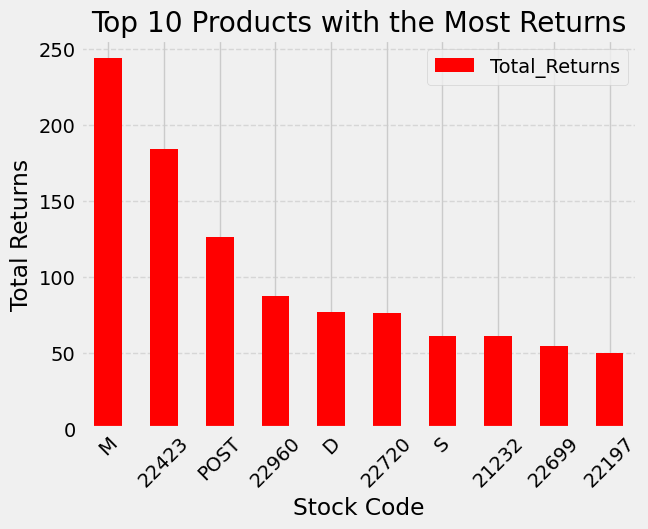

In [ ]:
product_return_counts = df_returns.groupby('StockCode')['Quantity'].count().reset_index()
product_return_counts.rename(columns={'Quantity': 'Total_Returns'}, inplace=True)

top_returned_products = product_return_counts.sort_values(by='Total_Returns', ascending=False)

top_10_returned_products = top_returned_products.head(10)
# Plot bar chart
plt.figure(figsize=(12, 6))
top_10_returned_products.plot(x='StockCode', y='Total_Returns', kind='bar', color='red')

plt.xlabel("Stock Code")
plt.ylabel("Total Returns")
plt.title("Top 10 Products with the Most Returns")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

####  Identify Customers Who Return the Most
Now that we have identified the most returned products, let's analyze which customers return the most and how frequently.

<Figure size 1200x600 with 0 Axes>

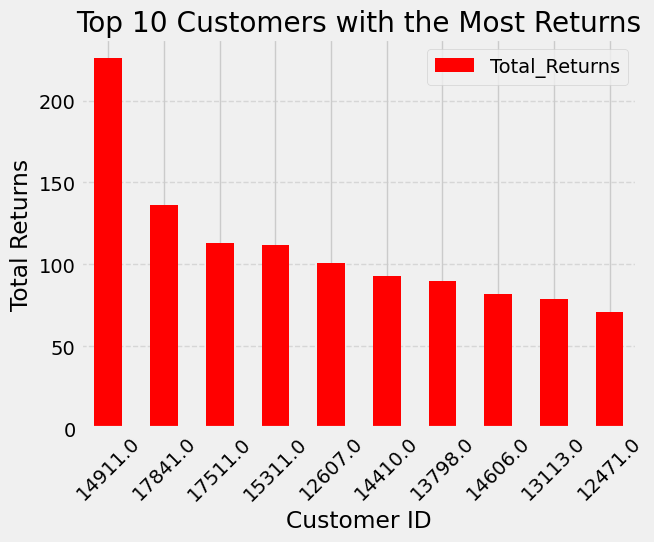

In [ ]:
customer_return_counts = df_returns[df_returns['CustomerID'] != 'Unknown_Customer'].groupby('CustomerID')['Quantity'].count().reset_index()
customer_return_counts.rename(columns={'Quantity': 'Total_Returns'}, inplace=True)

top_returning_customers = customer_return_counts.sort_values(by='Total_Returns', ascending=False)

top_10_customers = top_returning_customers.head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
top_10_customers.plot(x='CustomerID', y='Total_Returns', kind='bar', color='red')

plt.xlabel("Customer ID")
plt.ylabel("Total Returns")
plt.title("Top 10 Customers with the Most Returns")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Looks like 'Unkown_Customer' (customers with no CustomerID) are returning the most followed by other customers. Though we can't specifically know the reason of their returns (insufficient data).

Let's check **which products and customers causes most revenue loss**.

#### Top Products Causing Revenue Loss

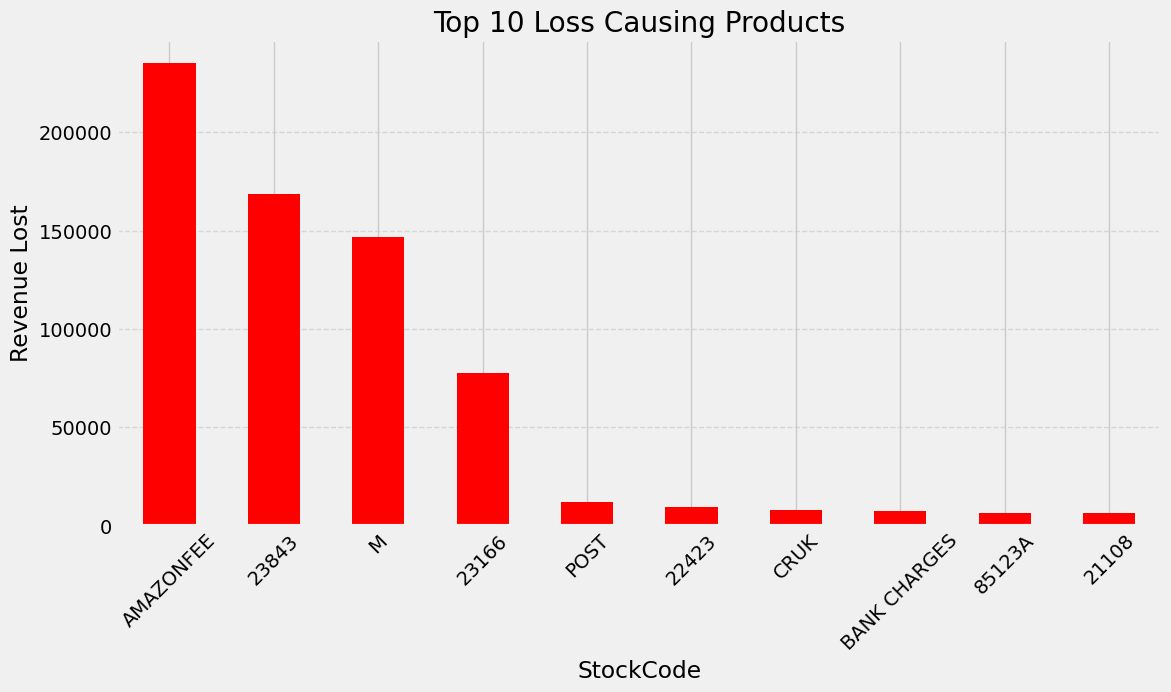

In [ ]:
top_loss_causing_products = df_returns.groupby('StockCode')['Revenue_lost'].sum().sort_values(ascending=False)
top_10_loss_causing_products = top_loss_causing_products.head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
top_10_loss_causing_products.plot(kind='bar', color='red')
plt.xlabel("StockCode")
plt.ylabel("Revenue Lost")
plt.title("Top 10 Loss Causing Products")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

#### Top Customers Causing Revenue Loss

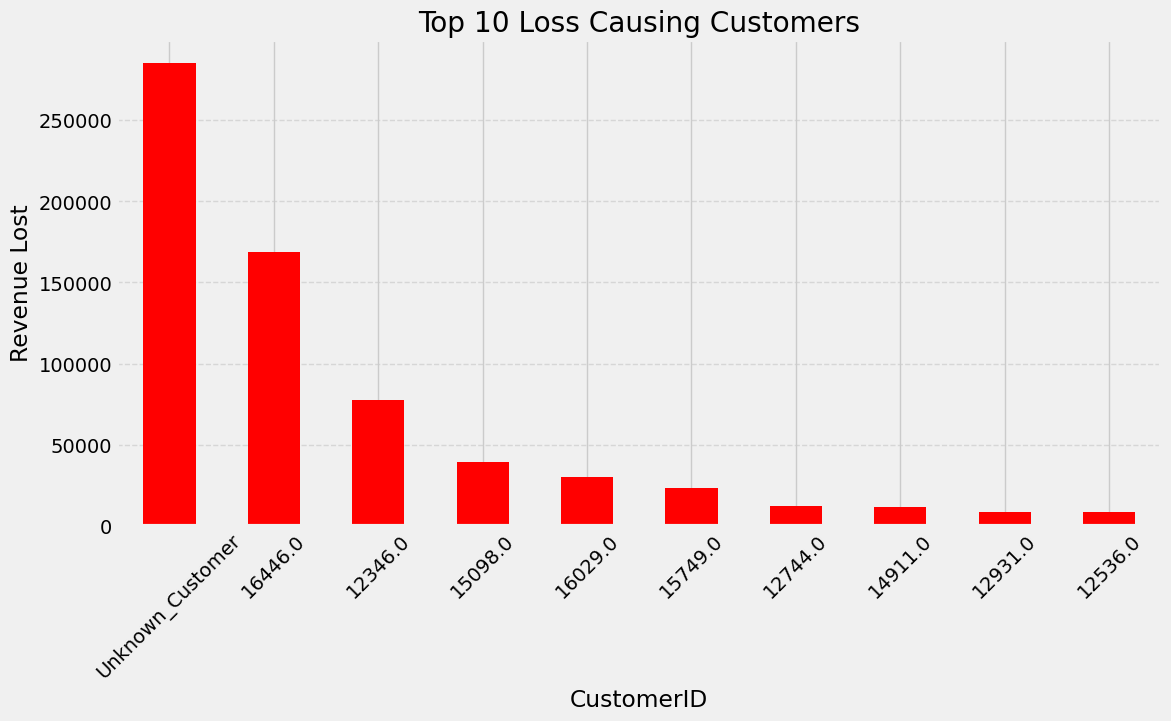

In [ ]:
top_loss_causing_products = df_returns.groupby('CustomerID')['Revenue_lost'].sum().sort_values(ascending=False)
top_10_loss_causing_products = top_loss_causing_products.head(10)

# Plot bar chart
plt.figure(figsize=(12, 6))
top_10_loss_causing_products.plot(kind='bar', color='red')
plt.xlabel("CustomerID")
plt.ylabel("Revenue Lost")
plt.title("Top 10 Loss Causing Customers")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
top_loss_causing_products

,Revenue_lost
CustomerID,
Unknown_Customer,285470.40
16446.0,168469.60
12346.0,77183.60
15098.0,39267.00
16029.0,30032.23
...,...
17164.0,0.95
12421.0,0.77
16566.0,0.65


[]

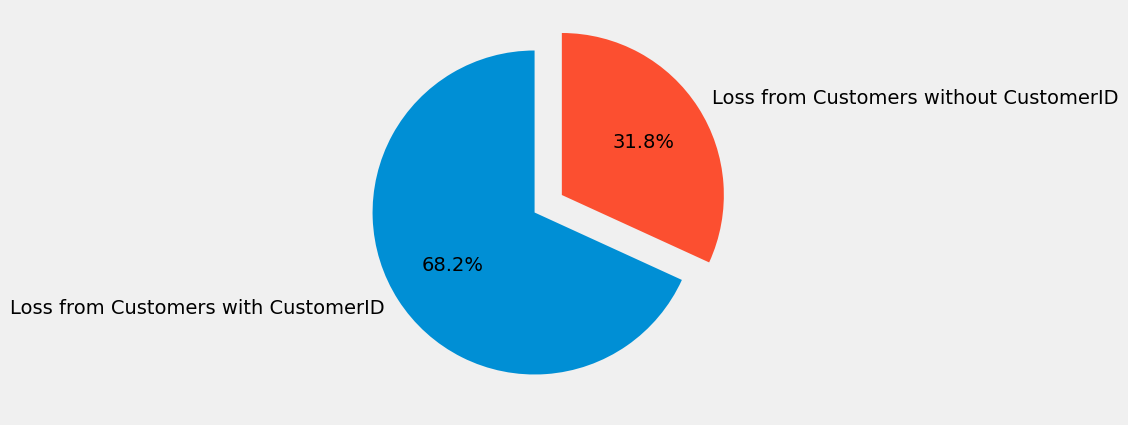

In [ ]:
total_loss_with_cust_id = top_loss_causing_products.iloc[1:].sum()
total_loss_without_cust_id = top_loss_causing_products.iloc[0]
plt.figure(figsize=(10,5))
plt.pie([total_loss_with_cust_id, total_loss_without_cust_id], labels=['Loss from Customers with CustomerID', 'Loss from Customers without CustomerID'], autopct='%1.1f%%', startangle=90, explode=[0,0.2])
plt.plot()

#### Return Patterns Over Time
Are returns increasing or decreasing over months?
Do returns spike during specific seasons


<Figure size 1200x600 with 0 Axes>

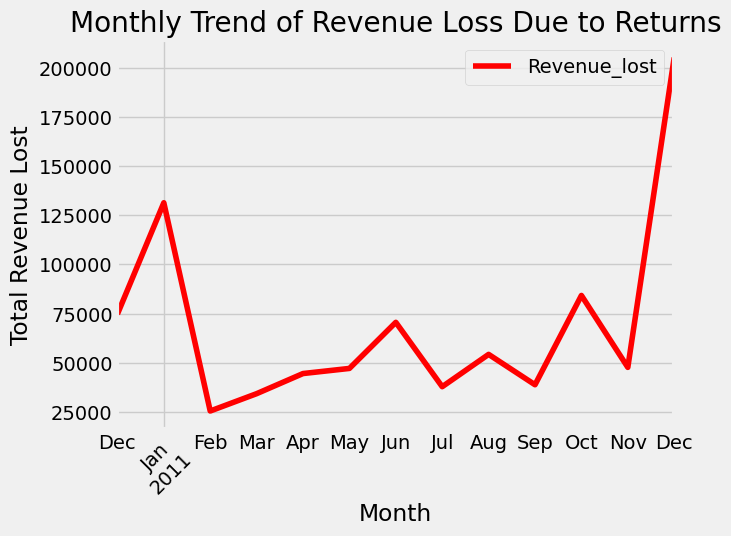

In [ ]:
# Extract month and analyze return trends
df_returns["ReturnMonth"] = df_returns["InvoiceDate"].dt.to_period("M")

# Aggregate revenue lost per month
monthly_return_trend = df_returns.groupby("ReturnMonth")["Revenue_lost"].sum().reset_index()

# Visualization
plt.figure(figsize=(12, 6))
monthly_return_trend.plot(x="ReturnMonth", y="Revenue_lost", kind="line", color="red")
plt.xlabel("Month")
plt.ylabel("Total Revenue Lost")
plt.title("Monthly Trend of Revenue Loss Due to Returns")
plt.xticks(rotation=45)
plt.show()


#### Country-Wise Return Analysis
* Are some countries returning more than others?
* Are international returns higher than domestic ones?


<Figure size 1200x600 with 0 Axes>

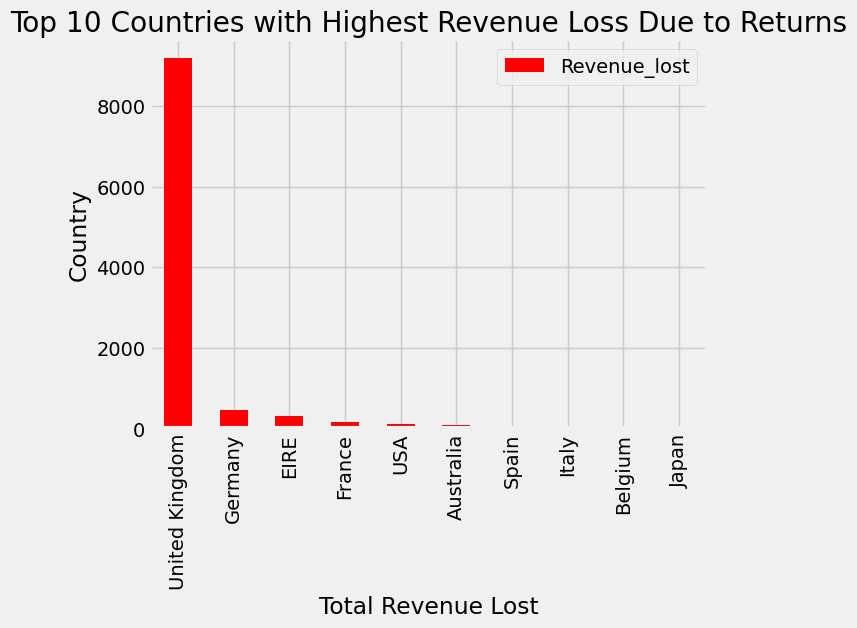

In [ ]:
# Aggregate revenue lost per country
country_return_loss = df_returns.groupby("Country")["Revenue_lost"].count().reset_index()

# Get top 10 countries by revenue loss
top_countries_loss = country_return_loss.sort_values(by="Revenue_lost", ascending=False).head(10)

# Visualization
plt.figure(figsize=(12, 6))
top_countries_loss.plot(x="Country", y="Revenue_lost", kind="bar", color="red")
plt.xlabel("Total Revenue Lost")
plt.ylabel("Country")
plt.title("Top 10 Countries with Highest Revenue Loss Due to Returns")
plt.show()

## Key Takeaways & Business Implications:
Return revenue is **~9.2%** of total sales revenue (896,812.49 out of 9,747,747.93)

* Action: Focus on reducing high-return products/customers to improve profitability.
---
#### Top 10 Most Returned Products Identified

* Action: Check product descriptions, quality issues, or misleading advertising.
---
#### Top 10 Customers Who Return the Most Identified

* Action: Investigate if these are repeat returners due to dissatisfaction, fraud, or bulk orders.
---
#### High Revenue Loss Products Include Fees & Bank Charges

* Action: If return fees (like Amazon fees & bank charges) are major contributors, reconsider pricing or handling fees.
---
#### United Kingdom Leads in Return Revenue Loss

* Action: UK is the primary market, so this is expected. However, focus on minimizing UK returns by improving return policies.
---
#### Nov-Feb Sees the Highest Return Revenue Loss

* Action: This could be due to post-holiday returns (common in e-commerce).
* Strategies:
  * Stricter return policies during these months.
  * Offer exchanges instead of refunds to reduce losses.

# Customer Segmentation for Marketing Strategies

In [ ]:
df = data.copy()
df['Description'].fillna('Unknown', inplace=True)
df["CustomerID"] = df["CustomerID"].astype(str).replace("nan", "Unknown_Customer")
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df['IsReturned'] = (df['Quantity'] < 0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  541909 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
 8   Revenue      541909 non-null  float64       
 9   IsReturned   541909 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 41.3+ MB


#### Step 1: Aggregating Customer-Level Data
We'll create a new dataframe summarizing customer transactions. The key metrics per CustomerID will be:

* TotalRevenue -> Sum of revenue generated by the customer.
* TotalTransactions -> Count of invoices associated with the customer.
* TotalProductsPurchased -> Count of total quantity purchased.
* UniqueProductsPurchased -> Count of unique products bought.
* ReturnFrequency -> Count of return transactions for the customer.


In [ ]:
customer_data = df.groupby("CustomerID").agg(
    TotalRevenue=("Revenue", "sum"),
    TotalTransactions=("InvoiceNo", "nunique"),
    TotalProductsPurchased=("Quantity", "sum"),
    UniqueProductsPurchased=("StockCode", "nunique"),
    ReturnFrequency=("IsReturned", "sum")
).reset_index()

customer_data.head()

,CustomerID,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency
0,12346.0,0.00,2,0,1,1
1,12347.0,4310.00,7,2458,103,0
2,12348.0,1797.24,4,2341,22,0
3,12349.0,1757.55,1,631,73,0
4,12350.0,334.40,1,197,17,0


#### Step 2: Normalization (Feature Scaling)
Since clustering algorithms like K-Means are sensitive to scale, we’ll normalize the dataset using Min-Max Scaling.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = ["TotalRevenue", "TotalTransactions", "TotalProductsPurchased", "UniqueProductsPurchased", "ReturnFrequency"]

scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])
customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=features)
customer_data_scaled.head()

,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency
0,0.002953,0.000270,0.001123,0.000000,0.000582
1,0.005921,0.001618,0.010231,0.026779,0.000000
2,0.004191,0.000809,0.009797,0.005513,0.000000
3,0.004163,0.000000,0.003461,0.018903,0.000000
4,0.003183,0.000000,0.001853,0.004201,0.000000


###Step 3: Determine Optimal Number of Clusters
We'll use Elbow Method and Silhouette Score to find the best number of clusters for K-Means.

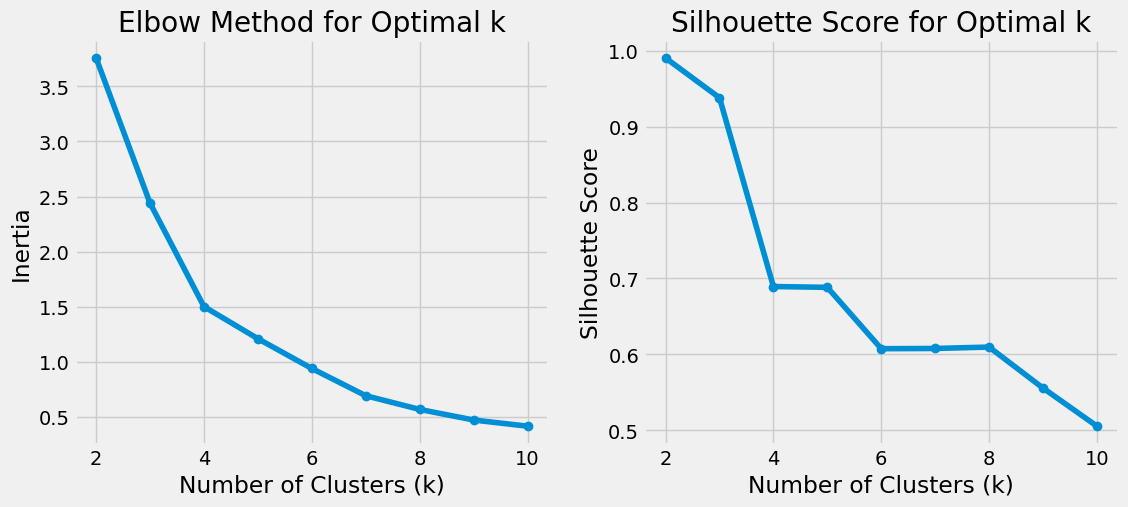

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

cluster_range = range(2, 11)
inertia_values = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_data_scaled)

    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_data_scaled, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")

plt.show()

#### Step 4: Apply K-Means with k=2

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
customer_data_scaled["Cluster"] = kmeans.fit_predict(customer_data_scaled)

customer_data["Cluster"] = customer_data_scaled["Cluster"]

numeric_columns = customer_data.select_dtypes(include=["number"]).columns

cluster_summary = customer_data.groupby("Cluster")[numeric_columns].mean()
cluster_summary

,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency,Cluster
Cluster,,,,,,
0,1.898460e+03,5.07548,1122.344007,61.211116,2.036825,0.0
1,1.447682e+06,3710.00000,269562.000000,3810.000000,1719.000000,1.0


#### Step 5: Visualize the Clusters

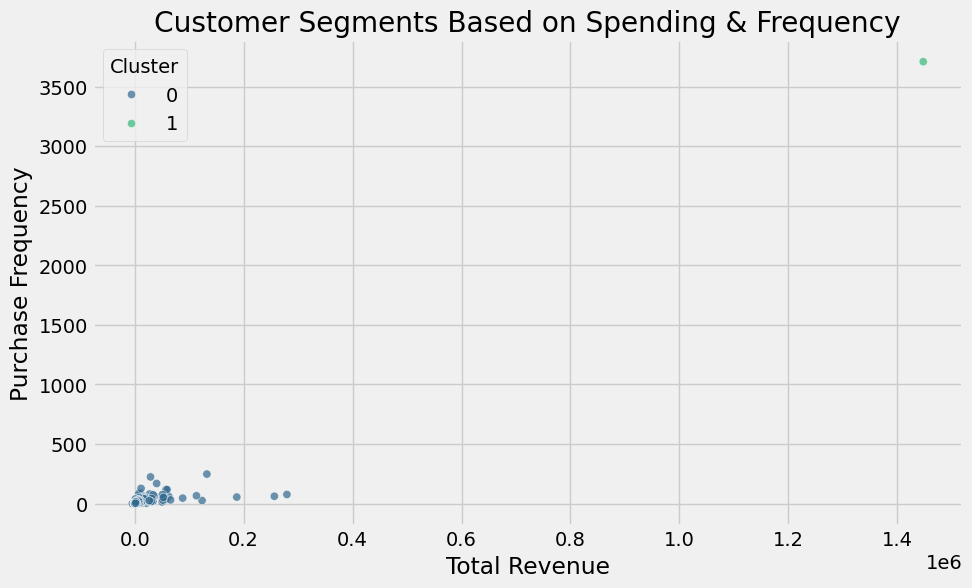

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data["TotalRevenue"],
    y=customer_data["TotalTransactions"],
    hue=customer_data["Cluster"],
    palette="viridis",
    alpha=0.7
)
plt.xlabel("Total Revenue")
plt.ylabel("Purchase Frequency")
plt.title("Customer Segments Based on Spending & Frequency")
plt.legend(title="Cluster")
plt.show()

Looks like there is an outlier. Let's analyse it.

In [ ]:
customer_data.sort_values(by=["TotalRevenue"], ascending=False).head(5)

,CustomerID,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency,Cluster
4372,Unknown_Customer,1447682.12,3710,269562,3810,1719,1
1703,14646.0,279489.02,77,196719,703,5,0
4233,18102.0,256438.49,62,64122,151,2,0
3758,17450.0,187482.17,55,69029,127,14,0
1895,14911.0,132572.62,248,77180,1794,226,0


It's 'Unkown_Customer'. Let's remove it because we can't do much about it and re-run the clustering from **Step 1**.

#### Removing Outlier

#### Step 1 (and removing the outlier)

In [ ]:
customer_data = df.groupby("CustomerID").agg(
    TotalRevenue=("Revenue", "sum"),
    TotalTransactions=("InvoiceNo", "nunique"),
    TotalProductsPurchased=("Quantity", "sum"),
    UniqueProductsPurchased=("StockCode", "nunique"),
    ReturnFrequency=("IsReturned", "sum")
).reset_index()

# Removing the outlier
customer_data = customer_data[customer_data['CustomerID'] != 'Unknown_Customer']
customer_data.head()

,CustomerID,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency
0,12346.0,0.00,2,0,1,1
1,12347.0,4310.00,7,2458,103,0
2,12348.0,1797.24,4,2341,22,0
3,12349.0,1757.55,1,631,73,0
4,12350.0,334.40,1,197,17,0


#### Step 2

In [ ]:
scaler = MinMaxScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])
customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=features)
customer_data_scaled.head()

,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency
0,0.015109,0.004049,0.001538,0.000000,0.004425
1,0.030297,0.024291,0.014014,0.056888,0.000000
2,0.021442,0.012146,0.013420,0.011712,0.000000
3,0.021303,0.000000,0.004741,0.040156,0.000000
4,0.016288,0.000000,0.002538,0.008924,0.000000


#### Step 3

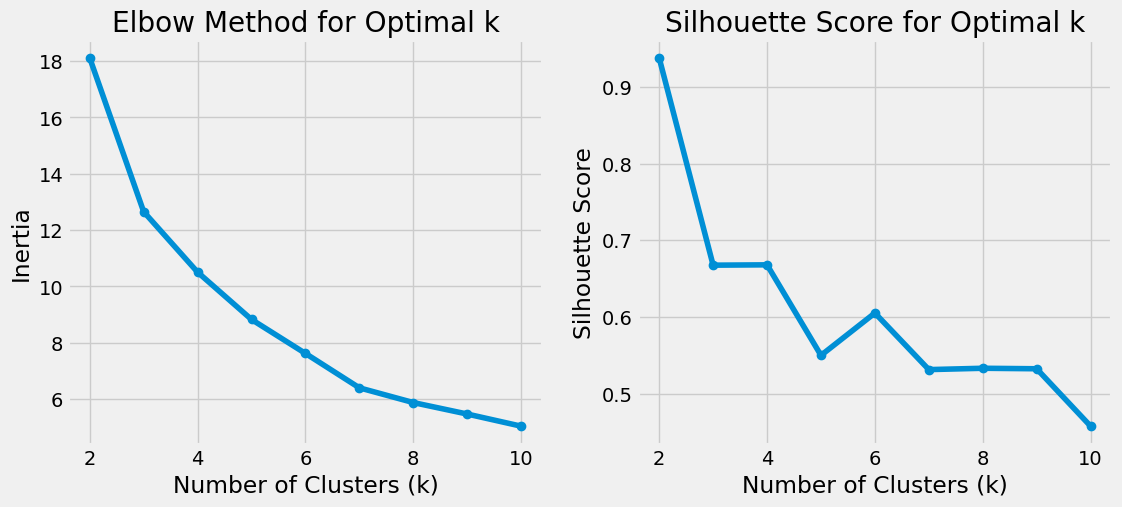

In [ ]:
cluster_range = range(2, 11)
inertia_values = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_data_scaled)

    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(customer_data_scaled, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Optimal k")

plt.show()

#### Step 4

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
customer_data_scaled["Cluster"] = kmeans.fit_predict(customer_data_scaled)

customer_data["Cluster"] = customer_data_scaled["Cluster"]

numeric_columns = customer_data.select_dtypes(include=["number"]).columns

cluster_summary = customer_data.groupby("Cluster")[numeric_columns].mean()
cluster_summary

,TotalRevenue,TotalTransactions,TotalProductsPurchased,UniqueProductsPurchased,ReturnFrequency,Cluster
Cluster,,,,,,
0,1549.295420,4.754189,928.354372,58.687170,1.83865,0.0
1,103319.044667,98.400000,57469.866667,794.333333,59.60000,1.0


#### Step 5

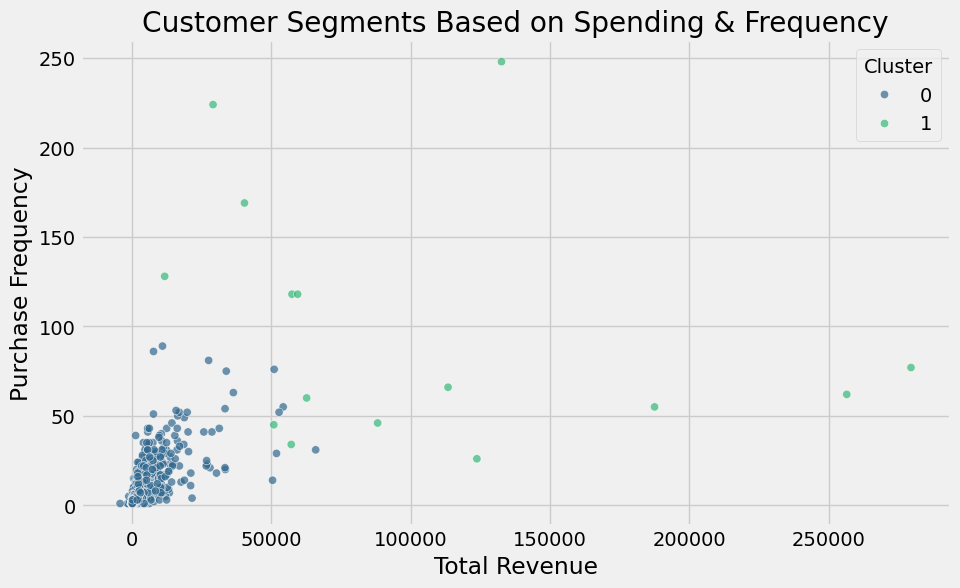

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_data["TotalRevenue"],
    y=customer_data["TotalTransactions"],
    hue=customer_data["Cluster"],
    palette="viridis",
    alpha=0.7
)
plt.xlabel("Total Revenue")
plt.ylabel("Purchase Frequency")
plt.title("Customer Segments Based on Spending & Frequency")
plt.legend(title="Cluster")
plt.show()

## Observations

K-Means (K=2) was the best clustering approach based on the Elbow Method & Silhouette Score.
### Cluster 0 – Regular Shoppers
* Majority of customers fall in this group.
* They make occasional purchases with lower total spending.
* Fewer product returns (Return Frequency = 1.84).
#### Recommendations:
* Can be targeted with promotions & loyalty programs to increase engagement.

---

## Cluster 1 – High-Value Customers
* These customers spend significantly more.
* They make frequent purchases and buy a wide variety of products.
* Higher return frequency (59.6), indicating potential dissatisfaction or bulk purchasing behaviour.
#### Recommendations:
* Can be offered premium services (exclusive deals, faster shipping, or VIP support).
* High return rates may require stricter return policies or improved quality assurance.
